In [1]:
## Packages

using Random
using Distributions
using Plots
using Printf
;

In [2]:
## Random seed for reproducibility

USE_RANDOM_SEED = false
RANDOM_SEED_VALUE = 314
if USE_RANDOM_SEED
    Random.seed!(RANDOM_SEED_VALUE)
end
;

In [3]:
## Game parameters

K = 7    # Number of bandit arms
T = 1000 # Number of timesteps
;

In [4]:
## Distribution parameters

X_MIN   = 0    # Lower limit of the distributions
X_MAX   = 1    # Higher limit of the distributions
STD_MIN = 0.01 # Minimal standard deviation of the distributions
STD_MAX = 0.2  # Maximal standard deviation of the distributions
;

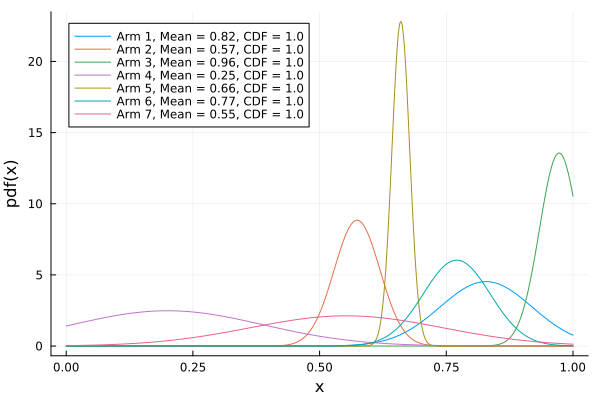

In [5]:
## Generate and plot distributions

arm_avg         = zeros(K) # Mean value of the distribution for each arm (before truncation)
arm_std         = zeros(K) # Standard deviation of the distribution for each arm (before truncation)
arm_expectation = zeros(K) # Expectation (i.e., mean value) of the distribution for each arm (after truncation)

p = plot(xlabel = "x", ylabel = "pdf(x)", legend = :topleft)
xx = 0:1e-3:1

for k in 1:K
    
    # Randomly sample distribution properties
    arm_avg[k] = rand(Uniform(X_MIN, X_MAX))
    arm_std[k] = rand(Uniform(STD_MIN, STD_MAX))
            
    # Construct the normal distribution (arm_avg[k], arm_std[k]) truncated within [X_MIN, X_MAX]
    d = Truncated(Normal(arm_avg[k], arm_std[k]), X_MIN, X_MAX)
 
    # Calculate the expected value
    arm_expectation[k] = mean(d)
    
    # Plot distributions
    plot!(
        xx, pdf.(d, xx),
        label = @sprintf("Arm %d, Mean = %0.2f, CDF = %0.1f", k, arm_expectation[k], cdf(d, X_MAX)))

end

display(p)

# Store the maximum expected value
max_expected_value = maximum(arm_expectation)
;

In [6]:
## Hyperparameters for the epsilon-greedy strategy

epsilon_ini   = 0.5  # Promote exploration instead of exploitation (within [0, 1])
epsilon_decay = 0.99 # Incremental decrease of epsilon (within [0, 1])
;

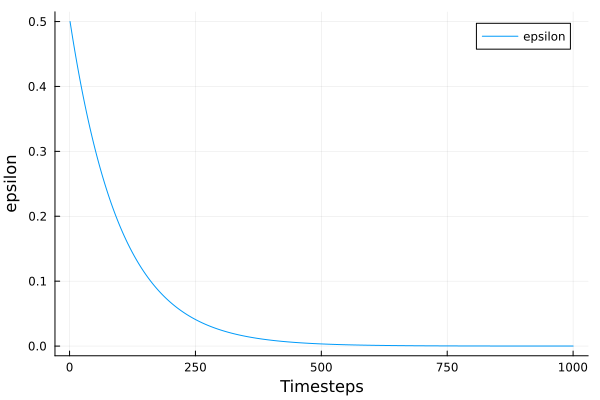

In [7]:
## Generate and plot the epsilon-greedy strategy

epsilon    = zeros(T)
epsilon[1] = epsilon_ini
for t in 1:T-1
    epsilon[t+1] = epsilon[t] * epsilon_decay
end

p = plot(xlabel = "Timesteps", ylabel = "epsilon", legend = :topright)
plot!(1:T, epsilon, label = "epsilon")
display(p)
;

In [8]:
## Solve the game using the epsilon-greedy Q-learning algorithm

nb_pulls_per_arm           = zeros(K) # Store the total number of pulls per arm
rewards_cumulative_per_arm = zeros(K) # Store the total amount of rewards received per arm
pulled_arm                 = zeros(T) # Store the index of the arm that was pulled at timestep t (for display purposes)

Q                         = zeros(T+1, K) # Quality table (with temporal memory, for display purposes)
rewards_instantaneous     = zeros(T+1)    # Instantaneous rewards (for display purposes)
rewards_cumulative         = zeros(T+1)    # Cumulative rewards
regret                    = zeros(T+1)    # Regret
expectation_instantaneous = zeros(T+1)    # Instantaneous expectation (for display purposes)
rewards_random_cumulative = zeros(T+1)    # Cumulative rewards when pulling at random (for comparison purposes)

for t in 2:T+1
    
    if rand(Uniform(0, 1)) < epsilon[t-1]
        # Exploration
        k_select = rand(1:K)
    else
        # Exploitation (TODO: randomly break ties)
        k_select = mapslices(argmax, Q[t, :], dims = 1)[1]
    end
    
    # Store the index of the arm that was pulled (for display purposes)
    pulled_arm[t-1] = k_select
    
    # Obtain reward
    rewards_instantaneous[t] = rand(Truncated(Normal(arm_avg[k_select], arm_std[k_select]), X_MIN, X_MAX), 1)[1]

    # Update the known information for the selected arm
    rewards_cumulative_per_arm[k_select] += rewards_instantaneous[t]
    nb_pulls_per_arm[k_select] += 1
    
    # Update the quality table
    # (For display purpose, pulling one arm updates the present and all future values of the table)
    Q[t:(T+1), k_select] .= rewards_cumulative_per_arm[k_select] / nb_pulls_per_arm[k_select]
    
    # Update the regret
    regret[t] = regret[t-1] + max_expected_value - arm_expectation[k_select]  
      
    # Update the cumulative rewards
    rewards_cumulative[t] = rewards_cumulative[t-1] + rewards_instantaneous[t]
    
    # Update the instantaneous expectation (for display purposes)
    expectation_instantaneous[t] = arm_expectation[k_select]
    
    # Pull one arm at random and store the corresponding results (for comparison purposes)
    k_random = rand(1:K)
    reward_random_instantaneous = rand(Truncated(Normal(arm_avg[k_random], arm_std[k_random]), X_MIN, X_MAX), 1)[1]
    rewards_random_cumulative[t] = rewards_random_cumulative[t-1] + reward_random_instantaneous

end
;

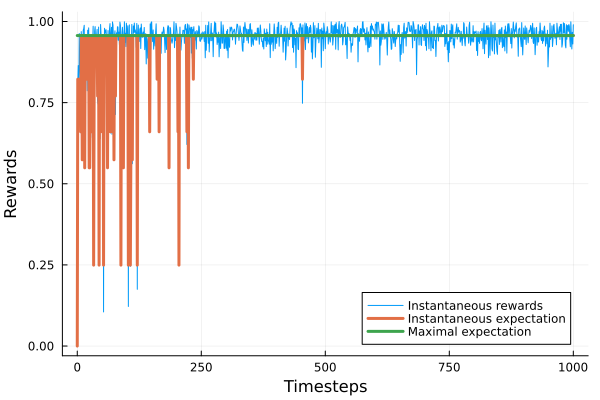

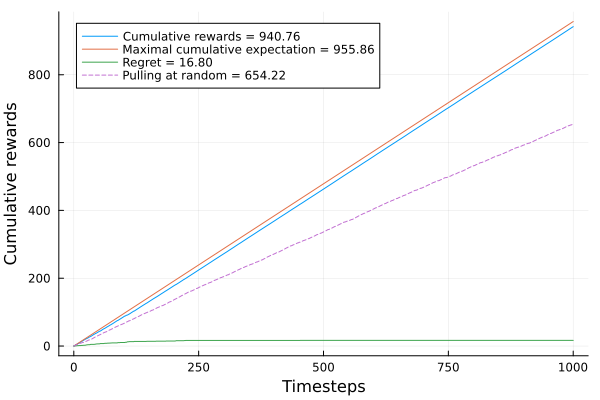

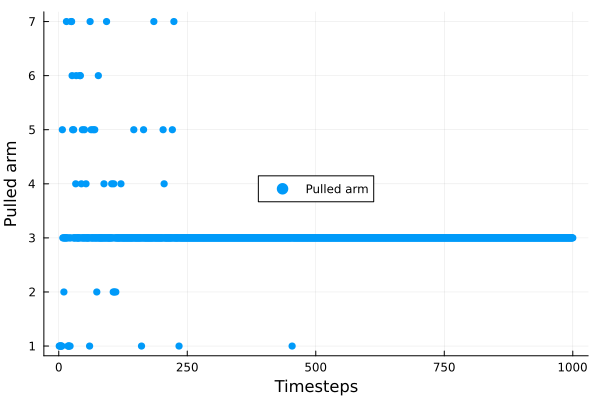

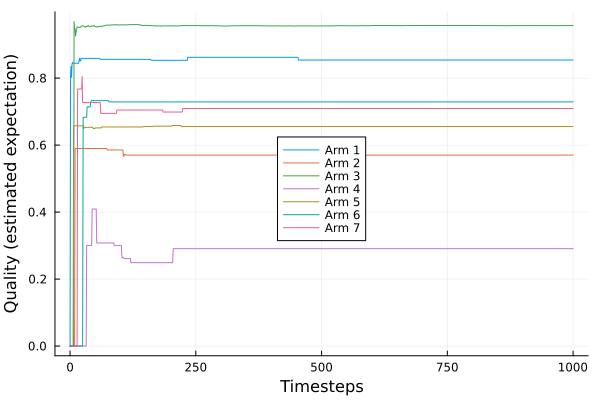

In [9]:
## Plot results

maximal_expectation = ones(T+1) * max_expected_value
maximal_expectation_cumulative = (0:T) * max_expected_value

p = plot(xlabel = "Timesteps", ylabel = "Rewards", legend = :bottomright)
plot!(0:T, rewards_instantaneous, label = "Instantaneous rewards")
plot!(0:T, expectation_instantaneous, linewidth = 3, label = "Instantaneous expectation")
plot!(0:T, maximal_expectation, linewidth = 3, label = "Maximal expectation")
display(p)

p = plot(xlabel = "Timesteps", ylabel = "Cumulative rewards")
plot!(
    0:T, rewards_cumulative, 
    label = @sprintf("Cumulative rewards = %0.2f", rewards_cumulative[T]), legend = :topleft)
plot!(
    0:T, maximal_expectation_cumulative,
    label = @sprintf("Maximal cumulative expectation = %0.2f", maximal_expectation_cumulative[T]))
plot!(
    0:T, regret,
    label = @sprintf("Regret = %0.2f", regret[T]))
plot!(
    0:T, rewards_random_cumulative,
    linestyle = :dash,
    label = @sprintf("Pulling at random = %0.2f", rewards_random_cumulative[T]))
display(p)

p = plot(xlabel = "Timesteps", ylabel = "Pulled arm", legend = :inside)
scatter!(1:T, pulled_arm, markerstrokewidth = 0, label = "Pulled arm")
display(p)

p = plot(xlabel = "Timesteps", ylabel = "Quality (estimated expectation)", legend = :inside)
for k in 1:K
    plot!(0:T, Q[:, k], label = string("Arm ", k))
end
display(p)
;